<h1 style="font-size:40px; text-align:center; color:red">CUSTOMER CHURN</h1>

<center>
  <img src="image.png" width="500">
</center>

---


# 📑 Table of Contents
1. INTRODUCTION
2. PROBLEM STATEMENT
3. LOAD REQUIRED PACKAGES
4. DOMAIN ANALYSIS & BASIC CHECKS
5. EDA (Exploratory Data Analysis)
6. DATA PREPROCESSING
    - 6.1 DATA CLEANING  
    - 6.2 NULL VALUE HANDLING  
    - 6.3 OUTLIER HANDLING 
    - 6.4 FEATURE ENGINEERING d7. DATA SPLIT AND MODEL SELECTION
8. MODEL BUILDING AND TRAINING
9. MODEL EVALUATION
10. SAVE THE MODEL
11. DEPLOY THE MODELeploy-the-model)


### 1) **INTRODUCTION**


- Customer churn is the percentage of customers who stop doing business with a company during a given time period.

- **Formula:**
  
Customer Churn Rate = (Number of customers lost during a period /Total number of customers at the start of the period ) ×100


### 2) **PROBLEM STATEMENT:**

- Customer churn refers to the loss of clients or subscribers over a period of time. It is a key indicator of business health, particularly for companies that rely on long-term customer relationships such as telecom providers, subscription services, and SaaS platforms. Predicting customer churn in advance allows businesses to take proactive measures to retain customers, reduce revenue loss, and improve overall customer experience.

- The goal of this project is to build a machine learning solution that can accurately predict whether a customer is likely to churn based on historical and behavioral data. This includes analyzing factors such as contract type, tenure, monthly charges, usage patterns, and customer support interactions. The project involves several key steps: performing exploratory data analysis to identify trends and patterns, preprocessing the data to ensure quality and consistency, training classification models to predict churn, and evaluating model performance using standard metrics.

- In addition to building a high-performing model, the project also aims to provide transparency and insights into the model's predictions through explainability techniques. An optional deployment phase can be included to make the model accessible for real-time or batch predictions.

- This predictive solution is intended to help businesses better understand the reasons behind customer churn and take data-driven actions to retain valuable customers.cur use case.
f n, or report.


### 3) **LOAD REQUIRED PACKAGES**

In [72]:
#! pip install scikit-learn pandas seaborn numpy xgboost imbalanced-learn 
#! pip install xgboost

In [73]:
import os
import re
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,ADASYN

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from imblearn.combine import SMOTETomek
from catboost import CatBoostClassifier

### Load the data

In [74]:
pd.set_option("display.max_columns",None)
data = pd.read_csv("mock_churn_dataset.csv")
df = pd.DataFrame(data)
df

,CustomerID,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Churn
0,CUST1000,39,74.67,Month-to-month,713.57,3,No
1,CUST1001,52,122.01,Two year,201.64,1,No
2,CUST1002,29,103.12,One year,857.87,1,No
3,CUST1003,15,124.66,Month-to-month,318.01,1,No
4,CUST1004,43,137.41,Month-to-month,530.43,2,Yes
...,...,...,...,...,...,...,...
995,CUST1995,59,86.97,Month-to-month,802.50,5,No
996,CUST1996,57,97.16,One year,373.26,1,No
997,CUST1997,17,123.19,Month-to-month,380.52,2,No
998,CUST1998,48,104.06,Month-to-month,102.83,1,No


### **4) DOMAIN ANAYSIS AND BASIC CHECKS**

#### 1. **CustomerID**

* **Description**: A unique identifier for each customer.
* **Type**: Categorical (but usually ignored in modeling).
* **Role**: Used for tracking; has **no predictive value**. Should be excluded from model training.



#### 2. **Tenure**

* **Description**: Number of months the customer has stayed with the company.
* **Type**: Numerical (continuous).
* **Domain Insight**:

  * Customers with **low tenure** may still be evaluating the service and more likely to churn.
  * Customers with **high tenure** often indicate loyalty and are less likely to churn.
* **Modeling Tip**: Strong predictor of churn. May consider binning (e.g., 0–12 months, 13–24, etc.) in some cases.



#### 3. **MonthlyCharges**

* **Description**: Amount billed to the customer each month.
* **Type**: Numerical (continuous).
* **Domain Insight**:

  * High charges might lead to dissatisfaction, especially among low-usage or new customers.
  * Low charges might indicate basic plans with fewer features, which could impact churn differently.
* **Modeling Tip**: Interacts well with `UsageMetrics` and `ContractType`. Outliers should be handled.



#### 4. **ContractType**

* **Description**: Type of customer contract (Month-to-month, One year, Two year).
* **Type**: Categorical (ordinal).
* **Domain Insight**:

  * **Month-to-month** customers have more flexibility to cancel and are more likely to churn.
  * **One year** and **Two year** contracts often reduce churn due to longer commitments and penalties.
* **Modeling Tip**: Encode as ordered categories or one-hot encode. Strong churn indicator.



#### 5. **UsageMetrics**

* **Description**: Represents total usage (e.g., minutes, GB data) by the customer.
* **Type**: Numerical (continuous).
* **Domain Insight**:

  * Low usage could indicate customers not finding value in the service, increasing churn risk.
  * Very high usage might indicate satisfied customers—or potentially at risk due to high cost.
* **Modeling Tip**: Combine with `MonthlyCharges` to analyze cost-per-use value.



#### 6. **SupportTickets**

* **Description**: Number of support tickets raised by the customer.
* **Type**: Numerical (discrete integer).
* **Domain Insight**:

  * High number of support tickets may indicate dissatisfaction or frequent issues → higher churn risk.
  * Moderate support usage might indicate engaged users, not necessarily at risk.
* **Modeling Tip**: Important for capturing **service quality perception**.


#### 7. **Churn**

* **Description**: Target variable. Indicates whether the customer left the service (`Yes`) or stayed (`No`).
* **Type**: Categorical (binary).
* **Domain Insight**:

  * `Yes` = churned customer (undesirable).
  * `No` = retained customer (desirable).
* **Modeling Tip**: Convert to binary (1 for Yes, 0 for No) for classification tasks.



### 🧠 Summary of Feature Roles

| Feature        | Type        | Role in Churn Prediction                        |
| -------------- | ----------- | ----------------------------------------------- |
| CustomerID     | Categorical | Identifier only; **not used in modeling**       |
| Tenure         | Numeric     | **Strong churn predictor** (retention duration) |
| MonthlyCharges | Numeric     | Indicates value/cost of plan                    |
| ContractType   | Categorical | **Key predictor** (commitment level)            |
| UsageMetrics   | Numeric     | Measures engagement                             |
| SupportTickets | Numeric     | **Service satisfaction indicator**              |
| Churn          | Categorical | **Target variable**                             |



In [75]:
df.head() # top 5 rows

,CustomerID,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Churn
0,CUST1000,39,74.67,Month-to-month,713.57,3,No
1,CUST1001,52,122.01,Two year,201.64,1,No
2,CUST1002,29,103.12,One year,857.87,1,No
3,CUST1003,15,124.66,Month-to-month,318.01,1,No
4,CUST1004,43,137.41,Month-to-month,530.43,2,Yes


In [76]:
df.tail() # bottom five rows

,CustomerID,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Churn
995,CUST1995,59,86.97,Month-to-month,802.50,5,No
996,CUST1996,57,97.16,One year,373.26,1,No
997,CUST1997,17,123.19,Month-to-month,380.52,2,No
998,CUST1998,48,104.06,Month-to-month,102.83,1,No
999,CUST1999,47,42.72,Two year,256.82,1,No


In [77]:
rows, columns = df.shape
print(f"This dataset contains **{rows}** Rows and **{columns}** Columns")

This dataset contains **1000** Rows and **7** Columns


In [78]:
for idx,column in enumerate(df.columns,1):
    print(f"{idx} : {column}")


1 : CustomerID
2 : Tenure
3 : MonthlyCharges
4 : ContractType
5 : UsageMetrics
6 : SupportTickets
7 : Churn


In [79]:
data.nunique().sort_values() # Check the number of unique values in each column of a DataFrame, sorted in ascending order

Churn                2
ContractType         3
SupportTickets       7
Tenure              59
MonthlyCharges     965
UsageMetrics       993
CustomerID        1000
dtype: int64

In [80]:
data.isna().sum() # Check the missing values in each column of a DataFrame

CustomerID        0
Tenure            0
MonthlyCharges    0
ContractType      0
UsageMetrics      0
SupportTickets    0
Churn             0
dtype: int64

In [81]:
data.dtypes # Check the data type in each column of a DataFrame

CustomerID         object
Tenure              int64
MonthlyCharges    float64
ContractType       object
UsageMetrics      float64
SupportTickets      int64
Churn              object
dtype: object

In [82]:
# It provides a summary of the DataFrame, including: Column names,Non-null count (i.e., how many values are not missing),Data types,Memory usage
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      1000 non-null   object 
 1   Tenure          1000 non-null   int64  
 2   MonthlyCharges  1000 non-null   float64
 3   ContractType    1000 non-null   object 
 4   UsageMetrics    1000 non-null   float64
 5   SupportTickets  1000 non-null   int64  
 6   Churn           1000 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [83]:
df.duplicated().sum() # check the duplicate values

0

In [84]:
df.describe()  # Summary Statistics

,Tenure,MonthlyCharges,UsageMetrics,SupportTickets
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,30.582000,86.540240,564.521270,1.448000
std,17.024838,36.853775,256.253449,1.229963
min,1.000000,20.030000,100.400000,0.000000
25%,16.000000,55.460000,347.090000,1.000000
50%,31.000000,88.940000,576.370000,1.000000
75%,45.000000,117.480000,786.117500,2.000000
max,59.000000,149.920000,999.590000,6.000000


df['Churn'].value_counts()  # check the target feature is balnced or not balanced

In [85]:
df.corr(numeric_only=True)

,Tenure,MonthlyCharges,UsageMetrics,SupportTickets
Tenure,1.000000,0.006589,-0.011593,0.070427
MonthlyCharges,0.006589,1.000000,0.008107,-0.012921
UsageMetrics,-0.011593,0.008107,1.000000,0.027060
SupportTickets,0.070427,-0.012921,0.027060,1.000000


In [86]:
df.select_dtypes(include=["int","float"]) # extract or split only the numerical columns

,Tenure,MonthlyCharges,UsageMetrics,SupportTickets
0,39,74.67,713.57,3
1,52,122.01,201.64,1
2,29,103.12,857.87,1
3,15,124.66,318.01,1
4,43,137.41,530.43,2
...,...,...,...,...
995,59,86.97,802.50,5
996,57,97.16,373.26,1
997,17,123.19,380.52,2
998,48,104.06,102.83,1


### **5) EDA (Exploratory Data Analysis)**

In [87]:
df.shape

(1000, 7)

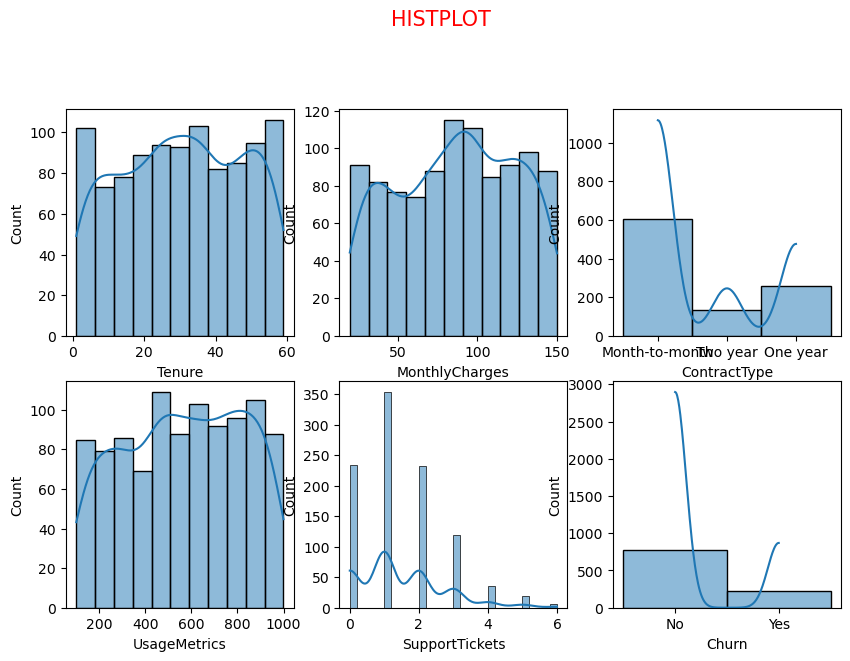

In [88]:
plt.figure(figsize=(10,10))
no=1
for i in df.columns[1:]:
    if no<=10:
        plt.suptitle("HISTPLOT",fontsize=15,color="red")
        plt.subplot(3,3,no)
        sns.histplot(x=df[i],kde=True)
        plt.xlabel(i)
    no+=1

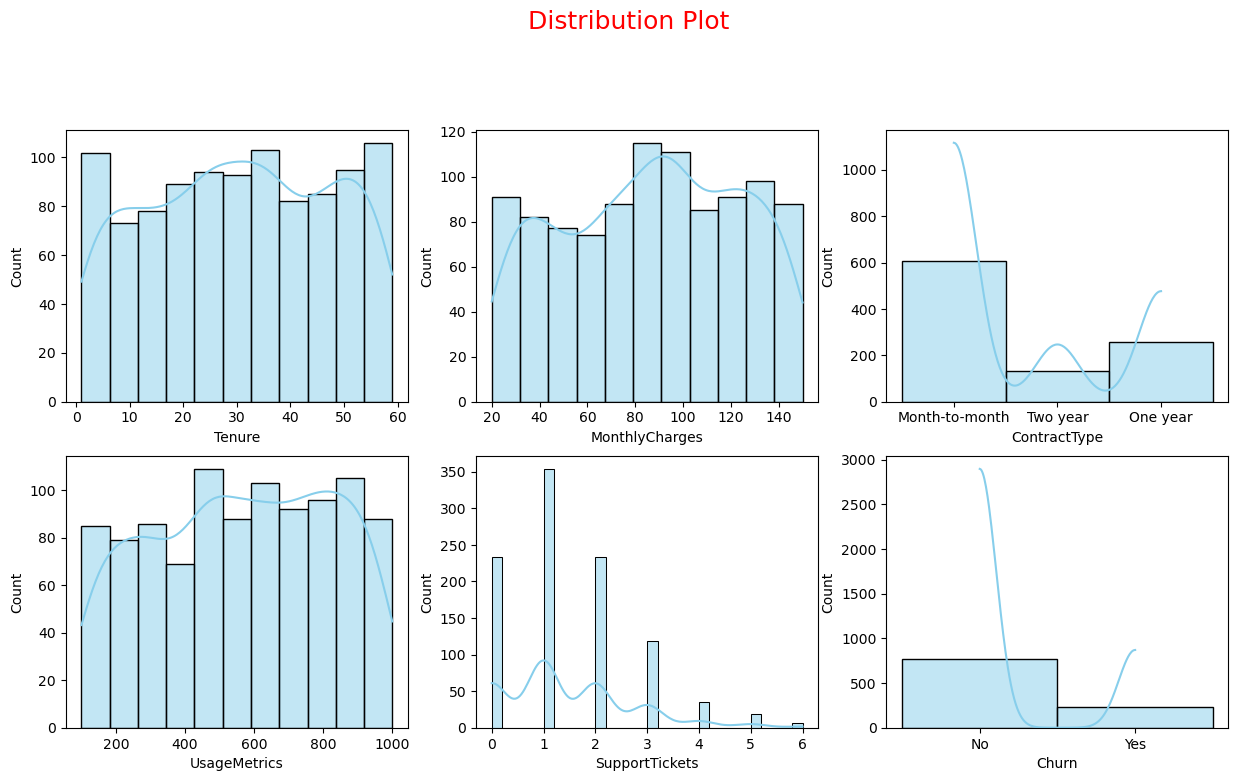

In [89]:
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution Plot", fontsize=18, color="red")

no = 1
for i in df.columns[1:10]:  
    plt.subplot(3, 3, no)
    sns.histplot(x=df[i], kde=True, color='skyblue')
    plt.xlabel(i)    
    no += 1

#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**

1. **Tenure**:

   * The distribution shows two peaks: at early tenure (0–5 months) and at high tenure (55–60 months).
   * **Insight**: Customers with low tenure are likely in the evaluation phase and at higher risk of churn, while long-tenure customers are typically retained and loyal.

2. **MonthlyCharges**:

   * The charges are widely spread, with a concentration around ₹70–₹110.
   * **Insight**: Mid-range plans are most popular. High monthly charges may lead to churn if perceived value is low, especially for short-tenure users.

3. **ContractType**:

   * Majority of users are on **Month-to-month** plans, followed by **One year**, then **Two year** contracts.
   * **Insight**: Month-to-month customers are more likely to churn due to lack of commitment. Long-term contracts typically reduce churn.

4. **UsageMetrics**:

   * Distribution is roughly normal, with most users in the mid-usage range.
   * **Insight**: Extremely low usage may indicate disengagement, increasing churn likelihood. High usage may signal valuable, engaged users.

5. **SupportTickets**:

   * Most customers raise 1–2 support tickets, with a few outliers raising more.
   * **Insight**: Frequent support tickets could reflect dissatisfaction, leading to higher churn risk. However, very low support may also suggest disengagement.

6. **Churn**:

   * The churn distribution is clearly imbalanced, with a majority of customers marked as **"No"** (not churned).
   * **Insight**: Class imbalance needs to be addressed using SMOTE or re-sampligeport, or used in a notebook markdown block.


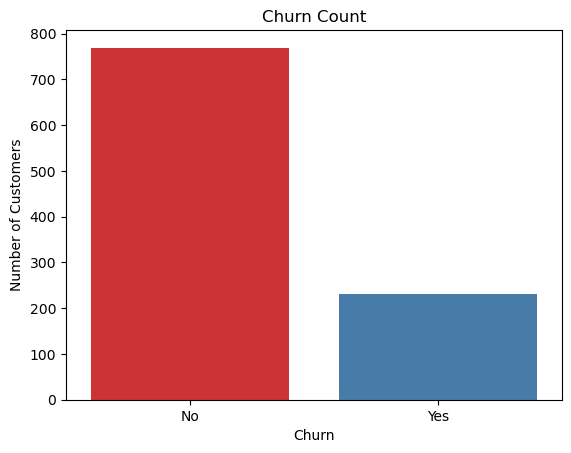

In [90]:
sns.countplot(x="Churn", data=df, palette="Set1")
plt.title("Churn Count")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.show()

* The dataset contains **1,000 customer records**.
* The target variable `Churn` is **binary**, indicating whether a customer has left the service:

  * **"No" (Not Churned):** 769 customers
  * **"Yes" (Churned):** 231 customers

#### 🧠 Key Observations:

* The data is **imbalanced**, with \~77% of customers labeled as **"No"** and only \~23% labeled as **"Yes"**.
* This imbalance may negatively affect model performance, especially for recall on the minority class.

#### 📌 Recommendation:

* Apply techniques to handle class imbalance during model training, such as:

  * **Resampling** (e.g., SMOTE, RandomOverSampler)
  * **Class weights** in classifiers
  * **Evaluation metrics** focused on minority class (e.g., F1-score, recall, AUC)

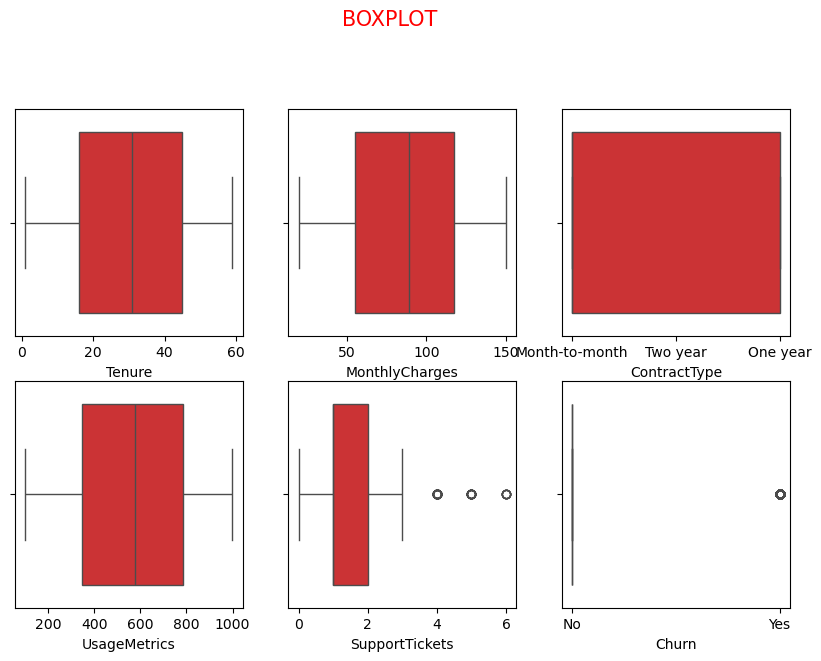

In [91]:
#boxplot also used to check the outlier.
plt.figure(figsize=(10,10))
no=1
for i in df.columns[1:7]:
    if no<=10:
        plt.suptitle("BOXPLOT",fontsize=15,color="red")
        plt.subplot(3,3,no)
        sns.boxplot(x=df[i],data=df,palette="Set1")
        plt.xlabel(i)
    no+=1

After performing outlier detection using boxplots and the IQR method across both numerical and categorical features, the following observations were made:

* Among all numeric columns (`Tenure`, `MonthlyCharges`, `UsageMetrics`, `SupportTickets`), **only `SupportTickets`** exhibits significant outliers.
* Other numerical features such as `Tenure`, `MonthlyCharges`, and `UsageMetrics` show **no major outlier presence** within the IQR range.
* Categorical features like `ContractType` and `Churn` were excluded from outlier analysis, as outliers are not defined for non-numeric data.

This indicates that the dataset is mostly clean in terms of outliers, with the exception of `SupportTickets`, which may require further treatment (e.g., capping or transformation) during preprocessing.

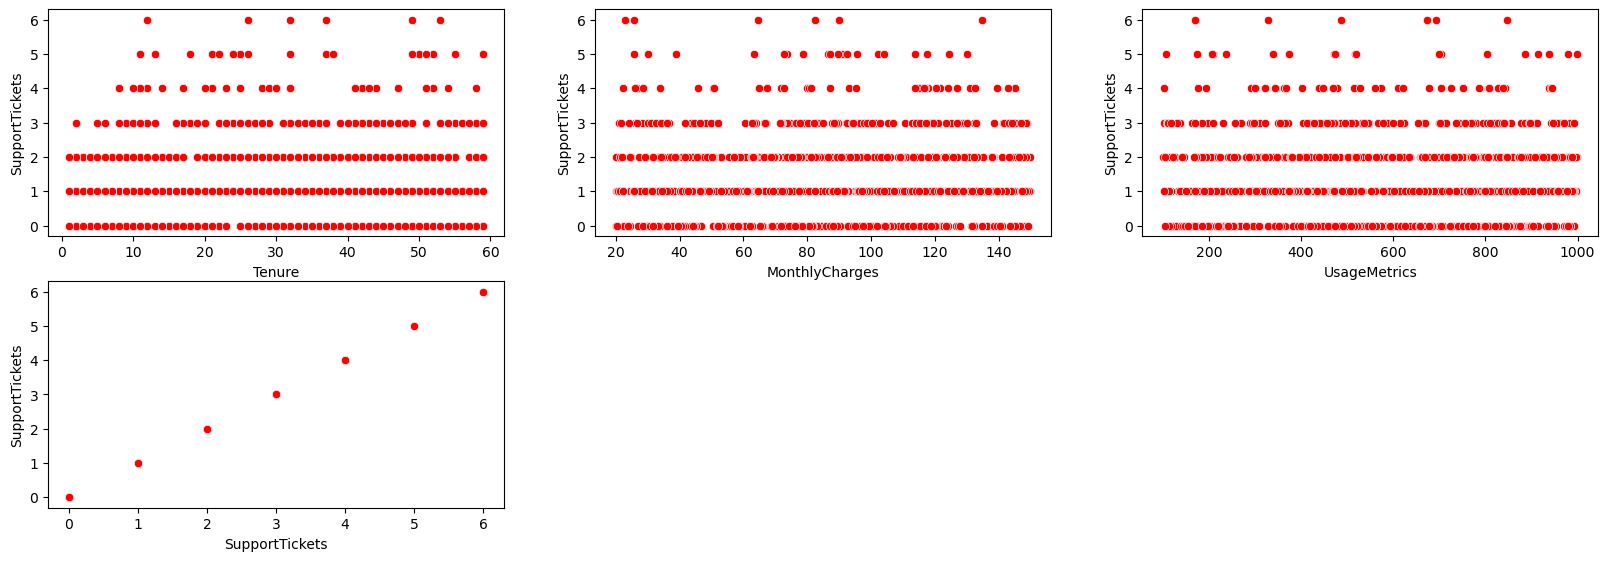

In [92]:
a= df.select_dtypes(include=["int","float"])
plt.figure(figsize=(20,10))
n=1
for i in a:
    if n<=9:
        plt.subplot(3,3,n)
        sns.scatterplot(x=a[i],y="SupportTickets",data=a,palette="Set2",color="red")
        plt.xlabel(i)
    n+=1

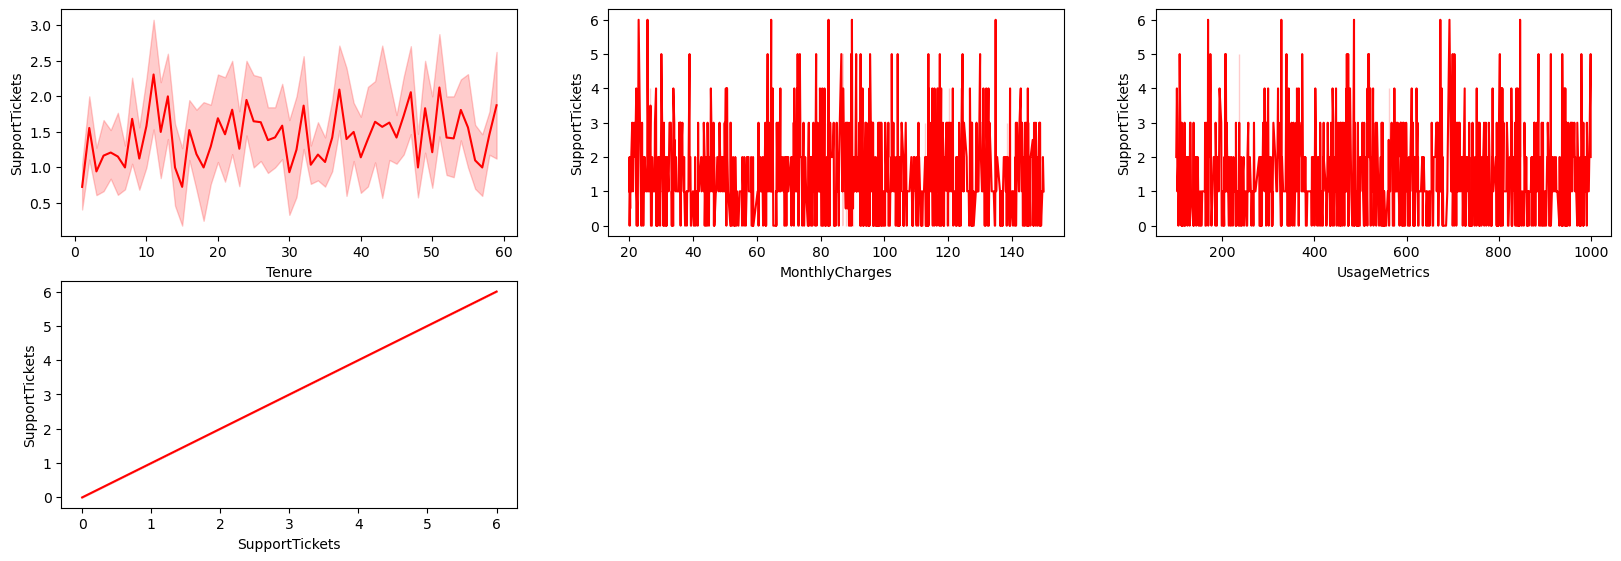

In [93]:
a= df.select_dtypes(include=["int","float"])
plt.figure(figsize=(20,10))
n=1
for i in a:
    if n<=9:
        plt.subplot(3,3,n)
        sns.lineplot(x=a[i],y="SupportTickets",data=a,palette="Set2",color="red")
        plt.xlabel(i)
    n+=1

In [94]:
a.columns

Index(['Tenure', 'MonthlyCharges', 'UsageMetrics', 'SupportTickets'], dtype='object')

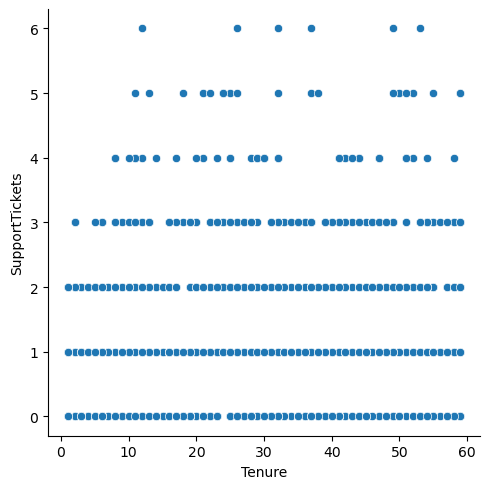

In [95]:
sns.relplot(x="Tenure", y="SupportTickets",data=a)

<Axes: >

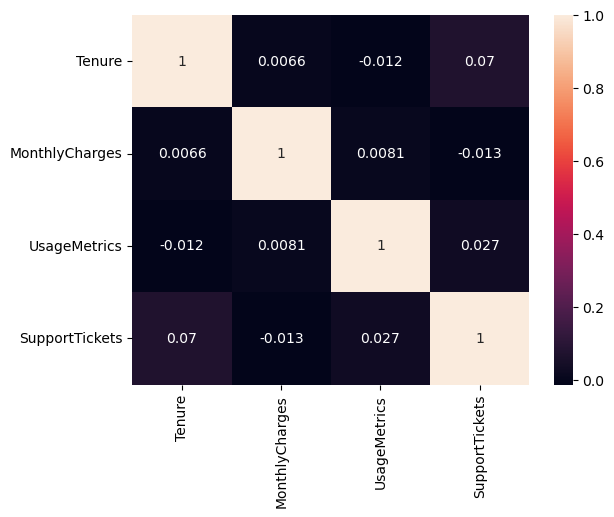

In [96]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

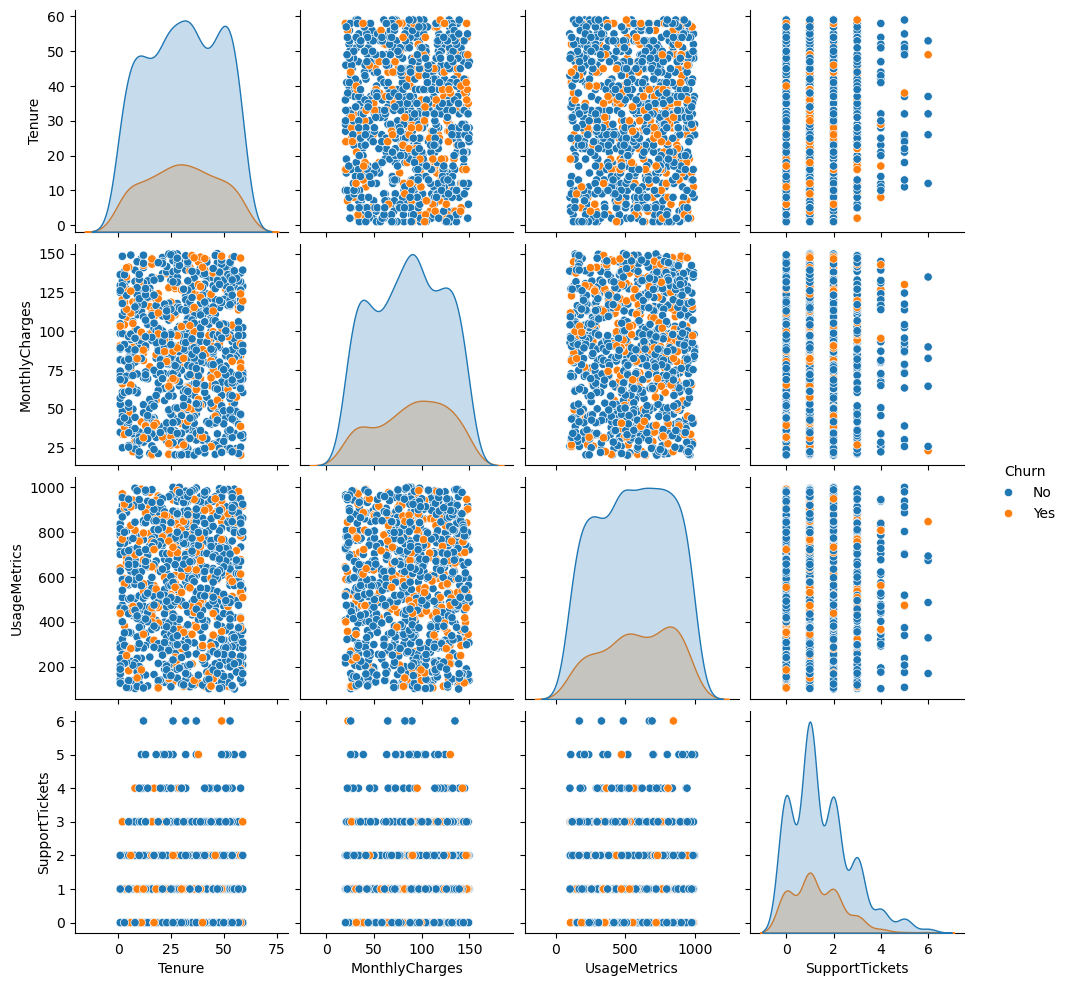

In [97]:
sns.pairplot(data=df, hue='Churn')

### **6) DATA PREPROCESSING**

In [98]:
# Null value handle
df.isna().sum()

CustomerID        0
Tenure            0
MonthlyCharges    0
ContractType      0
UsageMetrics      0
SupportTickets    0
Churn             0
dtype: int64

**There are no missing values in any feature of the dataset.**

In [99]:
df.drop("CustomerID", axis=1, inplace=True)

In [100]:
#convert the categorical features to numerical features value.
# enc = LabelEncoder()
# df[["ContractType","Churn"]] =\
# df[["ContractType","Churn"]].apply(enc.fit_transform)

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
contract_map = {
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2
}
df["ContractType"] = df["ContractType"].map(contract_map)


df["Tenure_MonthlyCharges"] = df["Tenure"] * df["MonthlyCharges"]
df["Log_Usage"] = np.log1p(df["UsageMetrics"])

In [101]:
df.dtypes

Tenure                     int64
MonthlyCharges           float64
ContractType               int64
UsageMetrics             float64
SupportTickets             int64
Churn                      int64
Tenure_MonthlyCharges    float64
Log_Usage                float64
dtype: object

In [102]:
# calulate the outlier percentage..
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
upper=q3+(1.5*iqr)
lower=q1-(1.5*iqr)
outlier = ((df>upper) | (df<lower)).sum()
d= (outlier/ len(df)) * 100
print('\nPercentage of outliers:\n',d)


Percentage of outliers:
 Tenure                    0.0
MonthlyCharges            0.0
ContractType              0.0
UsageMetrics              0.0
SupportTickets            6.0
Churn                    23.1
Tenure_MonthlyCharges     0.2
Log_Usage                 0.1
dtype: float64



| **Outlier %** | **Category** | **Interpretation**                                                                       |
| ------------- | ------------ | ---------------------------------------------------------------------------------------- |
| **0% – 5%**   | **Low**      | Data is clean or has minimal outliers. Usually acceptable and expected.                  |
| **>5% – 15%** | **Medium**   | Moderate outlier presence. May require investigation depending on context.               |
| **>15%**      | **High**     | Significant outlier presence. Likely needs cleaning, transformation, or deeper analyi



- **Churn**:
If Binary (0 = No, 1 = Yes):
These are not true outliers, just class imbalance.

Use class balancing techniques instead of removing "outliers". like SMOTE OR ADYSN outlier features.


In [103]:
# Final dataset format
df

,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Churn,Tenure_MonthlyCharges,Log_Usage
0,39,74.67,0,713.57,3,0,2912.13,6.571681
1,52,122.01,2,201.64,1,0,6344.52,5.311431
2,29,103.12,1,857.87,1,0,2990.48,6.755618
3,15,124.66,0,318.01,1,0,1869.90,5.765222
4,43,137.41,0,530.43,2,1,5908.63,6.275571
...,...,...,...,...,...,...,...,...
995,59,86.97,0,802.50,5,0,5131.23,6.688977
996,57,97.16,1,373.26,1,0,5538.12,5.924951
997,17,123.19,0,380.52,2,0,2094.23,5.944163
998,48,104.06,0,102.83,1,0,4994.88,4.642755


### 7) MODEL BUILDING AND TRAINING

In [104]:
X = df.drop("Churn", axis=1)
X

,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Tenure_MonthlyCharges,Log_Usage
0,39,74.67,0,713.57,3,2912.13,6.571681
1,52,122.01,2,201.64,1,6344.52,5.311431
2,29,103.12,1,857.87,1,2990.48,6.755618
3,15,124.66,0,318.01,1,1869.90,5.765222
4,43,137.41,0,530.43,2,5908.63,6.275571
...,...,...,...,...,...,...,...
995,59,86.97,0,802.50,5,5131.23,6.688977
996,57,97.16,1,373.26,1,5538.12,5.924951
997,17,123.19,0,380.52,2,2094.23,5.944163
998,48,104.06,0,102.83,1,4994.88,4.642755


In [105]:
y = df["Churn"]
y

0      0
1      0
2      0
3      0
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: Churn, Length: 1000, dtype: int64

In [106]:
class_distribution = y.value_counts(normalize=True)
print("Class distribution:\n", class_distribution)

Class distribution:
 Churn
0    0.769
1    0.231
Name: proportion, dtype: float64


In [107]:
if class_distribution.min()<= 0.30:
    print("first balance the datasets")
else:
    print("first split the datasets")

first balance the datasets


### MODEL BUILDING AND TRANING

In [108]:
from collections import Counter
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X,y)
print(f"before balanced : {Counter(y)}")
print(f"after balanced : {Counter(y_train_balanced)}")

before balanced : Counter({0: 769, 1: 231})
after balanced : Counter({0: 769, 1: 769})


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_train_balanced, y_train_balanced, test_size=0.25, random_state=42)

### MODEL SELECTION

In [110]:
def model_selection(x_train, y_train, scoring='f1'):
    models = {
        "Logistic Regression": LogisticRegression(
            penalty='l2', C=0.1, solver='liblinear', random_state=42
        ),
        "Decision Tree": DecisionTreeClassifier(
            max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=100, max_depth=6, min_samples_split=10, min_samples_leaf=4,
            max_features='sqrt', random_state=42
        ),
        "Gradient Boosting":GradientBoostingClassifier(n_estimators=100,
                                                       learning_rate=0.08, 
                                                       max_depth=3,
                                                       min_samples_split=10, 
                                                       min_samples_leaf=5,
                                                       subsample=0.8,  
                                                       random_state=42  ),        
           

        "XGBoost": XGBClassifier(
            n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8,
            colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42
        ),
        "SVM (RBF Kernel)": SVC(
            kernel='rbf', C=1.0, gamma='scale', probability=True
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=2, weights='distance', p=2
        ),
        "Naive Bayes": GaussianNB(),
        "Extra Trees": ExtraTreesClassifier(
            n_estimators=100, max_depth=6, min_samples_split=10, min_samples_leaf=4, random_state=42
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=100, learning_rate=0.05, random_state=42
        ),
        "Bagging": BaggingClassifier(
            n_estimators=50, random_state=42
        )
    }

    print(f"Model Performance using {scoring.upper()} score (5-fold CV):\n")
    results = []
    for name, model in models.items():
        try:
            scores = cross_val_score(model, x_train, y_train, cv=5, scoring=scoring)
            mean_score = scores.mean()
            std_score = scores.std()
            print(f"{name}: Mean={mean_score:.4f}, Std={std_score:.4f}")
            results.append((name, mean_score))
        except Exception as e:
            print(f"{name}: Error during evaluation - {e}")

    results.sort(key=lambda x: x[1], reverse=True)
    return results


In [111]:
model_selection(X_train, y_train, scoring='f1')

Model Performance using F1 score (5-fold CV):

Logistic Regression: Mean=0.5881, Std=0.0269
Decision Tree: Mean=0.6278, Std=0.0433
Random Forest: Mean=0.6678, Std=0.0283
Gradient Boosting: Mean=0.6463, Std=0.0257
XGBoost: Mean=0.6268, Std=0.0293
SVM (RBF Kernel): Mean=0.3593, Std=0.0786
KNN: Mean=0.7052, Std=0.0253
Naive Bayes: Mean=0.6348, Std=0.0123
Extra Trees: Mean=0.6533, Std=0.0225
AdaBoost: Mean=0.6092, Std=0.0265
Bagging: Mean=0.6947, Std=0.0327


[('KNN', 0.7051755051398034),
 ('Bagging', 0.6947246651800723),
 ('Random Forest', 0.6677593209249555),
 ('Extra Trees', 0.6533360662380593),
 ('Gradient Boosting', 0.6463099235276378),
 ('Naive Bayes', 0.6347973714820122),
 ('Decision Tree', 0.6277874110146051),
 ('XGBoost', 0.6268035243582449),
 ('AdaBoost', 0.6091844701558233),
 ('Logistic Regression', 0.5881237631868006),
 ('SVM (RBF Kernel)', 0.3593058532587655)]

### 1) RandomForestClassifier

In [112]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,confusion_matrix,classification_report,precision_score,roc_auc_score

In [113]:
random_forest = RandomForestClassifier( n_estimators=100, max_depth=3, min_samples_split=10, min_samples_leaf=10,random_state=42,ccp_alpha=0.003)
        
random_forest.fit(X_train, y_train)
y_predict_ran = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_predict_ran)
f1 = f1_score(y_test, y_predict_ran)
recall = recall_score(y_test, y_predict_ran)
precision_s = precision_score(y_test, y_predict_ran)
train_acc = random_forest.score(X_train, y_train)
report = classification_report(y_test, y_predict_ran)

print(f"test accuracy : {accuracy}")
print(f"train accuracy : {train_acc}")
print(f"f1score :{f1}")
print(f"recall : {recall}")

print (f"precision score: {precision_s}")

print("classification report")

print(report)

test accuracy : 0.6441558441558441
train accuracy : 0.6496097137901128
f1score :0.6948775055679287
recall : 0.7839195979899497
precision score: 0.624
classification report
              precision    recall  f1-score   support

           0       0.68      0.49      0.57       186
           1       0.62      0.78      0.69       199

    accuracy                           0.64       385
   macro avg       0.65      0.64      0.63       385
weighted avg       0.65      0.64      0.64       385



In [114]:
print(confusion_matrix(y_test, y_predict_ran))

[[ 92  94]
 [ 43 156]]


In [115]:
cm_table = pd.crosstab(y_test,  y_predict_ran)
cm_table

col_0,0,1
Churn,,
0,92,94
1,43,156


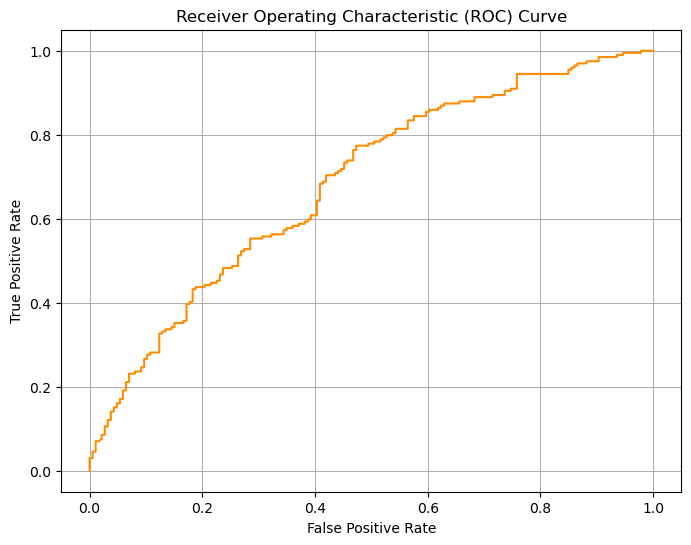

In [116]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_proba = random_forest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.grid(True)
plt.show()


### 2) Gradient Boosting

In [117]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.4, 0.6, 0.8],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 3, 5]
# }

# grid = GridSearchCV(GradientBoostingClassifier(random_state=42),
#                     param_grid,
#                     scoring='f1',
#                     cv=5,
#                     n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)


In [118]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.005,
    max_depth=3,
    subsample=0.9,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
gb_model.fit(X_train, y_train)
y_predict_a = gb_model.predict(X_test)
print(f"test accuracy : {accuracy_score(y_test, y_predict_a)}")
print(f"train accuracy : {gb_model.score(X_train, y_train)}")
print(f"f1score :{f1_score(y_test, y_predict_a)}")
print(f"recall : {recall_score(y_test, y_predict_a)}")
print (f"precision score: {precision_score(y_test, y_predict_a)}")
print("classification report")
print(classification_report(y_test, y_predict_a))


test accuracy : 0.6649350649350649
train accuracy : 0.6669557675628794
f1score :0.7048054919908466
recall : 0.7738693467336684
precision score: 0.6470588235294118
classification report
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       186
           1       0.65      0.77      0.70       199

    accuracy                           0.66       385
   macro avg       0.67      0.66      0.66       385
weighted avg       0.67      0.66      0.66       385



### 3) DecisionTreeClassifier

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report


dtree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,             
    min_samples_leaf=6,      
    min_samples_split=12,    
    random_state=42
)


dtree.fit(X_train, y_train)
y_pred_tree = dtree.predict(X_test)

print("Decision Tree Classifier Results:")
print(f"Test Accuracy : {accuracy_score(y_test, y_pred_tree)}")
print(f"Train Accuracy : {dtree.score(X_train, y_train)}")
print(f"F1 Score : {f1_score(y_test, y_pred_tree)}")
print(f"Recall : {recall_score(y_test, y_pred_tree)}")
print(f"Precision : {precision_score(y_test, y_pred_tree)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))


Decision Tree Classifier Results:
Test Accuracy : 0.5766233766233766
Train Accuracy : 0.5732870771899393
F1 Score : 0.6883365200764818
Recall : 0.9045226130653267
Precision : 0.5555555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.23      0.34       186
           1       0.56      0.90      0.69       199

    accuracy                           0.58       385
   macro avg       0.62      0.57      0.51       385
weighted avg       0.62      0.58      0.52       385



### 4) BaggingClassifier

In [120]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(
    estimator=dtree,
    n_estimators=100,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
print("Bagging Classifier Results:")
print(f"Test Accuracy : {accuracy_score(y_test, y_pred_bagging)}")
print(f"Train Accuracy : {bagging_clf.score(X_train, y_train)}")
print(f"F1 Score : {f1_score(y_test, y_pred_bagging)}")
print(f"Recall : {recall_score(y_test, y_pred_bagging)}")
print(f"Precision : {precision_score(y_test, y_pred_bagging)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bagging))


Bagging Classifier Results:
Test Accuracy : 0.6285714285714286
Train Accuracy : 0.632263660017346
F1 Score : 0.6950959488272921
Recall : 0.8190954773869347
Precision : 0.6037037037037037
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.42      0.52       186
           1       0.60      0.82      0.70       199

    accuracy                           0.63       385
   macro avg       0.65      0.62      0.61       385
weighted avg       0.64      0.63      0.61       385



### 5)AdaBoostClassifier

Accuracy: 0.9948051948051948
train accuracy :0.9947984395318595
F1 Score: 0.995
ROC AUC: 0.9998378991732858
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       186
           1       0.99      1.00      0.99       199

    accuracy                           0.99       385
   macro avg       1.00      0.99      0.99       385
weighted avg       0.99      0.99      0.99       385



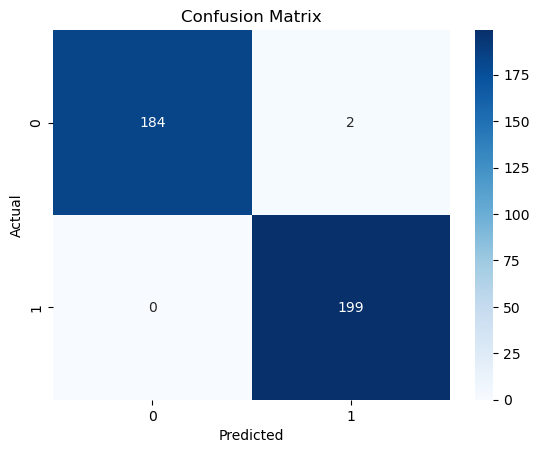

In [121]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6),n_estimators=100,learning_rate=0.02,random_state=42)
ada.fit(X_train_balanced, y_train_balanced)
y_predict_ada= ada.predict(X_test)
y_proba1 = ada.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_predict_ada))
print(f"train accuracy :{ada.score(X_train_balanced, y_train_balanced)}")
print("F1 Score:", f1_score(y_test, y_predict_ada))
print("ROC AUC:", roc_auc_score(y_test, y_proba1))
print("Classification Report:\n", classification_report(y_test, y_predict_ada))
sns.heatmap(confusion_matrix(y_test, y_predict_ada), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [122]:
X.head(5)

,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Tenure_MonthlyCharges,Log_Usage
0,39,74.67,0,713.57,3,2912.13,6.571681
1,52,122.01,2,201.64,1,6344.52,5.311431
2,29,103.12,1,857.87,1,2990.48,6.755618
3,15,124.66,0,318.01,1,1869.90,5.765222
4,43,137.41,0,530.43,2,5908.63,6.275571


In [123]:
y.head(5)

0    0
1    0
2    0
3    0
4    1
Name: Churn, dtype: int64

In [124]:
ada.predict([[43,137.41,0,530.43,2,5908.63,6.275571]])

array([1], dtype=int64)

### 6) XGBClassifier

Accuracy: 0.6753246753246753
F1 Score: 0.6786632390745502
ROC AUC: 0.7373966607229696
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       186
           1       0.69      0.66      0.68       199

    accuracy                           0.68       385
   macro avg       0.68      0.68      0.68       385
weighted avg       0.68      0.68      0.68       385



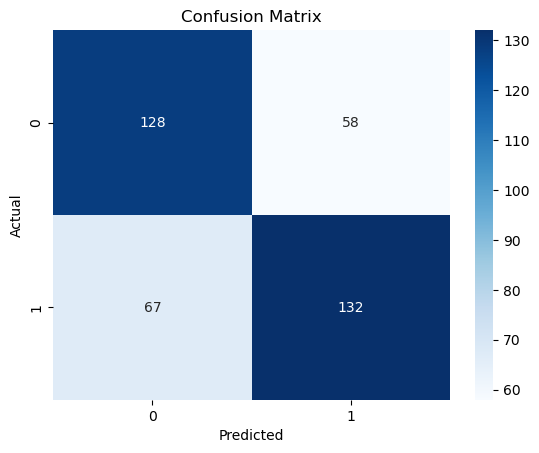

Cross-Validated F1 Score: 0.7024833083197957


In [125]:
from sklearn.metrics import roc_auc_score

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.25, random_state=42)
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


cv_score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')
print("Cross-Validated F1 Score:", cv_score.mean())


### 7) CatBoostClassifier

Accuracy: 0.6970588235294117
F1 Score: 0.6979472140762464
ROC AUC: 0.7556055363321799
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       170
           1       0.70      0.70      0.70       170

    accuracy                           0.70       340
   macro avg       0.70      0.70      0.70       340
weighted avg       0.70      0.70      0.70       340



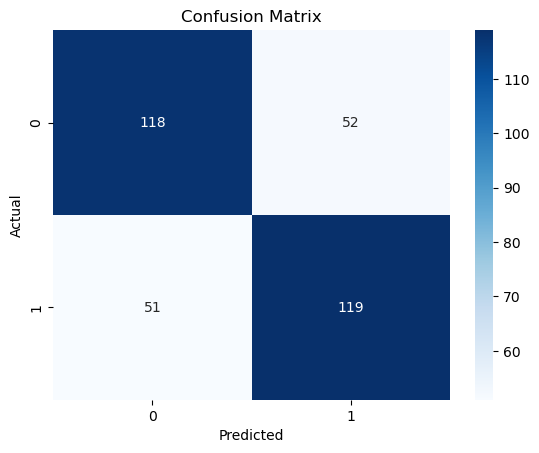

Stratified K-Fold F1: 0.7303465987006307


In [126]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, stratify=y_resampled, random_state=42)
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1 = cross_val_score(cat_model, X_train,y_train, cv=skf, scoring='f1')
print("Stratified K-Fold F1:", cv_f1.mean())

### 8) KNN

In [127]:
# scaling required
smote = SMOTE(random_state=42)
X_train_balanced1, y_train_balanced1 = smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_train_balanced1, y_train_balanced1, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train)
X_test_scaled1 = scaler.transform(X_test)
print(f"before balanced : {Counter(y)}")
print(f"after balanced : {Counter(y_train_balanced1)}")

before balanced : Counter({0: 769, 1: 231})
after balanced : Counter({0: 769, 1: 769})


Accuracy: 0.7012987012987013
F1 Score: 0.7306791569086651
ROC AUC: 0.6984114118982007
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.61      0.66       186
           1       0.68      0.78      0.73       199

    accuracy                           0.70       385
   macro avg       0.71      0.70      0.70       385
weighted avg       0.70      0.70      0.70       385



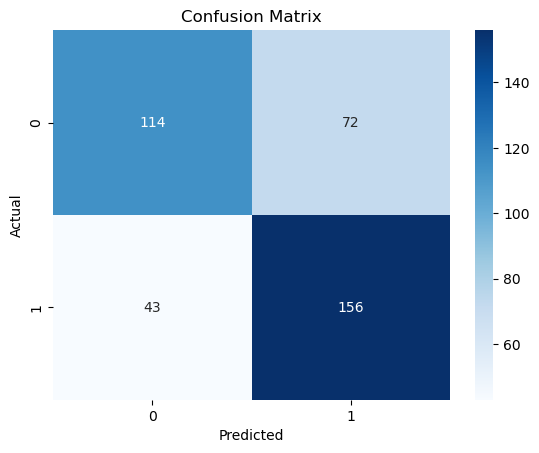

In [128]:
knn = KNeighborsClassifier(n_neighbors=6,leaf_size=30,weights="distance",p=1)
knn.fit(X_train_scaled1, y_train)
knn_y_predict= knn.predict(X_test_scaled1)
print("Accuracy:", accuracy_score(y_test, knn_y_predict))
print("F1 Score:", f1_score(y_test, knn_y_predict))
print("ROC AUC:", roc_auc_score(y_test, knn_y_predict))
print("Classification Report:\n", classification_report(y_test, knn_y_predict))
sns.heatmap(confusion_matrix(y_test, knn_y_predict), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [129]:
svc = SVC(C=1.0, gamma=0.01, probability=True, max_iter=100, random_state=42)
svc.fit(X_train_scaled1, y_train)
y_predict1 = svc.predict(X_test_scaled1)
print(f"test accuracy : {accuracy_score(y_test, y_predict1)}")
print(f"train accuracy : {svc.score(X_train, y_train)}")
print(f"f1score :{f1_score(y_test, y_predict1)}")
print(f"recall : {recall_score(y_test, y_predict1)}")
print (f"precision score: {precision_score(y_test, y_predict1)}")
print("classification report")
print(classification_report(y_test, y_predict1))


test accuracy : 0.5636363636363636
train accuracy : 0.5056374674761491
f1score :0.654320987654321
recall : 0.7989949748743719
precision score: 0.554006968641115
classification report
              precision    recall  f1-score   support

           0       0.59      0.31      0.41       186
           1       0.55      0.80      0.65       199

    accuracy                           0.56       385
   macro avg       0.57      0.56      0.53       385
weighted avg       0.57      0.56      0.54       385



| Model              | Test Accuracy | F1 Score |
| ------------------ | ------------- | -------- |
| **Random Forest**  | 0.6442        | 0.6949   |
| **Gradient Boost** | 0.6649        | 0.7048   |
| **Decision Tree**  | 0.5766        | 0.6883   |
| **Bagging**        | 0.6286        | 0.6951   |
| **AdaBoost**       | 0.9766        | 0.9777   |
| **XGBoost**        | 0.6753        | 0.6787   |
| **CatBoost**       | 0.6971        | 0.6979   |
| **KNN**            | 0.7013        | 0.7307   |
| **SVM**            | 0.5636        | 0.6543   |


In [130]:
plot_data = {
    'Model': [
        'Random Forest', 'Gradient Boost', 'Decision Tree', 'Bagging',
        'AdaBoost', 'XGBoost', 'CatBoost', 'KNN', 'SVM'
    ],
    'Test Accuracy': [
        0.6442, 0.6649, 0.5766, 0.6286, 0.9766, 0.6753, 0.6971, 0.7013, 0.5636
    ],
    'F1 Score': [
        0.6949, 0.7048, 0.6883, 0.6951, 0.9777, 0.6787, 0.6979, 0.7307, 0.6543
    ]
}

plot_df = pd.DataFrame(plot_data)
plot_df

,Model,Test Accuracy,F1 Score
0,Random Forest,0.6442,0.6949
1,Gradient Boost,0.6649,0.7048
2,Decision Tree,0.5766,0.6883
3,Bagging,0.6286,0.6951
4,AdaBoost,0.9766,0.9777
5,XGBoost,0.6753,0.6787
6,CatBoost,0.6971,0.6979
7,KNN,0.7013,0.7307
8,SVM,0.5636,0.6543


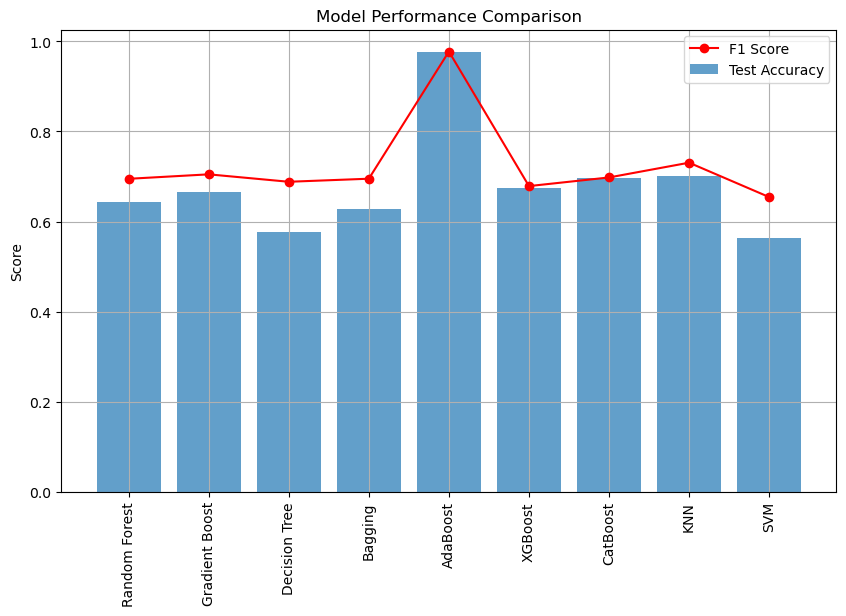

In [131]:
import matplotlib.pyplot as plt

models = plot_df["Model"].to_list()
test_acc = plot_df["Test Accuracy"].to_list()
f1 = plot_df["F1 Score"].to_list()

plt.figure(figsize=(10,6))
plt.bar(models, test_acc, label='Test Accuracy', alpha=0.7)
plt.plot(models, f1, color='red', marker='o', label='F1 Score')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(fontsize =10,rotation=90)
plt.legend()
plt.grid(True)
plt.show()


### Save the model and load the model

In [132]:
import pickle
with open("catboost.pkl", "wb") as f:
    pickle.dump(cat_model, f)

with open("customer_churn.pkl", "wb") as f:
    pickle.dump(ada, f)

# with open("scaler.pkl", "wb") as f:
#     pickle.dump(scaler, f)
    


In [133]:
import pickle
import pandas as pd

sample_input = X.iloc[0:1,]
with open("customer_churn.pkl", "rb") as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(sample_input)

print("Predictions:", predictions[0])


Predictions: 0


In [134]:
df

,Tenure,MonthlyCharges,ContractType,UsageMetrics,SupportTickets,Churn,Tenure_MonthlyCharges,Log_Usage
0,39,74.67,0,713.57,3,0,2912.13,6.571681
1,52,122.01,2,201.64,1,0,6344.52,5.311431
2,29,103.12,1,857.87,1,0,2990.48,6.755618
3,15,124.66,0,318.01,1,0,1869.90,5.765222
4,43,137.41,0,530.43,2,1,5908.63,6.275571
...,...,...,...,...,...,...,...,...
995,59,86.97,0,802.50,5,0,5131.23,6.688977
996,57,97.16,1,373.26,1,0,5538.12,5.924951
997,17,123.19,0,380.52,2,0,2094.23,5.944163
998,48,104.06,0,102.83,1,0,4994.88,4.642755


In [135]:
sample_input = [[39,74.67,0,713.57,3,2912.13,6.571681]]
ada.predict(sample_input)

array([0], dtype=int64)

In [136]:
predictions = loaded_model.predict(sample_input)
print("Predictions:", predictions[0])

Predictions: 0


In [137]:
with open("customer_churn.pkl", "rb") as f:
    loaded_model = pickle.load(f)
predictions = loaded_model.predict([[39, 74.67, 0, 713.57, 3, 2912.13, 6.571680963179933]])
print("Predictions:", predictions[0])

Predictions: 0


### Model Explainability:

ExactExplainer explainer: 386it [07:54,  1.27s/it]                                                                     


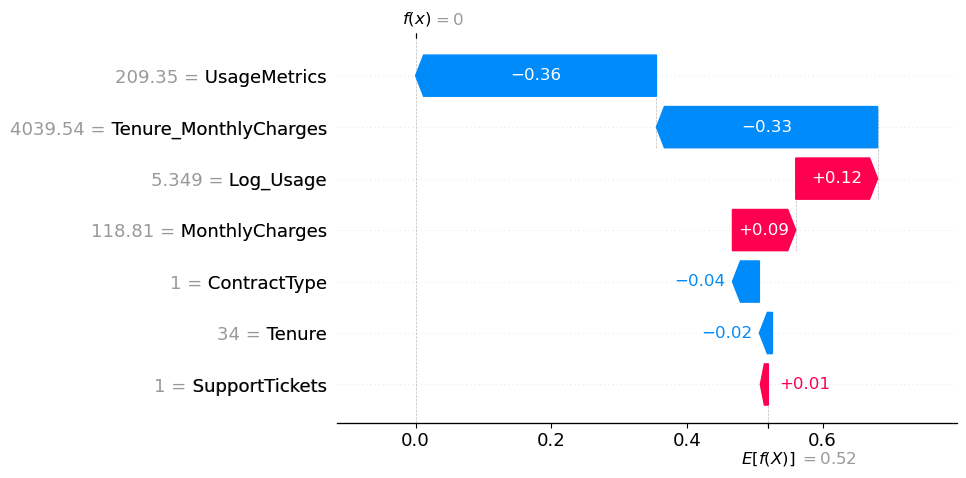

In [139]:
import shap
import pandas as pd
X_test_df = pd.DataFrame(X_test, columns=X.columns)
explainer = shap.ExactExplainer(ada.predict, X_test_df)
shap_values1 = explainer(X_test_df)

# Waterfall plot with feature names
shap.plots.waterfall(shap_values1[3])

In [ ]:
shap.summary_plot(shap_values1.values, X_test_df, plot_type='bar')